In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer

In [83]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
numerics_df = pd.read_pickle("./porsches_df.pkl")
numerics_df.describe()

,mileage,price,engine_size,doors,0-6Xmph,top_speed,cylinders,power,convertible,manual,years_old
count,1560.000000,1560.000000,1560.000000,1560.0,1560.000000,1560.000000,1560.0,1560.000000,1560.000000,1560.000000,1560.000000
mean,39252.214103,79019.195513,3.521154,2.0,4.308462,185.842949,6.0,409.132692,0.330128,0.270513,9.392308
std,32558.468638,52847.684672,0.344090,0.0,0.733313,8.820152,0.0,77.685388,0.470410,0.444367,6.693027
min,10.000000,8950.000000,3.000000,2.0,2.700000,118.000000,6.0,250.000000,0.000000,0.000000,0.000000
25%,12637.500000,37898.750000,3.000000,2.0,3.700000,179.000000,6.0,350.000000,0.000000,0.000000,4.000000
50%,30971.500000,73990.000000,3.600000,2.0,4.300000,187.000000,6.0,400.000000,0.000000,0.000000,8.000000
75%,60019.250000,104000.000000,3.800000,2.0,4.800000,191.000000,6.0,444.000000,1.000000,1.000000,15.000000
max,286000.000000,495990.000000,4.000000,2.0,5.900000,211.000000,6.0,690.000000,1.000000,1.000000,32.000000


In [85]:
numerics_df = numerics_df.drop(columns=["doors", "cylinders"])

In [86]:
numerics_df.describe()

,mileage,price,engine_size,0-6Xmph,top_speed,power,convertible,manual,years_old
count,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000
mean,39252.214103,79019.195513,3.521154,4.308462,185.842949,409.132692,0.330128,0.270513,9.392308
std,32558.468638,52847.684672,0.344090,0.733313,8.820152,77.685388,0.470410,0.444367,6.693027
min,10.000000,8950.000000,3.000000,2.700000,118.000000,250.000000,0.000000,0.000000,0.000000
25%,12637.500000,37898.750000,3.000000,3.700000,179.000000,350.000000,0.000000,0.000000,4.000000
50%,30971.500000,73990.000000,3.600000,4.300000,187.000000,400.000000,0.000000,0.000000,8.000000
75%,60019.250000,104000.000000,3.800000,4.800000,191.000000,444.000000,1.000000,1.000000,15.000000
max,286000.000000,495990.000000,4.000000,5.900000,211.000000,690.000000,1.000000,1.000000,32.000000


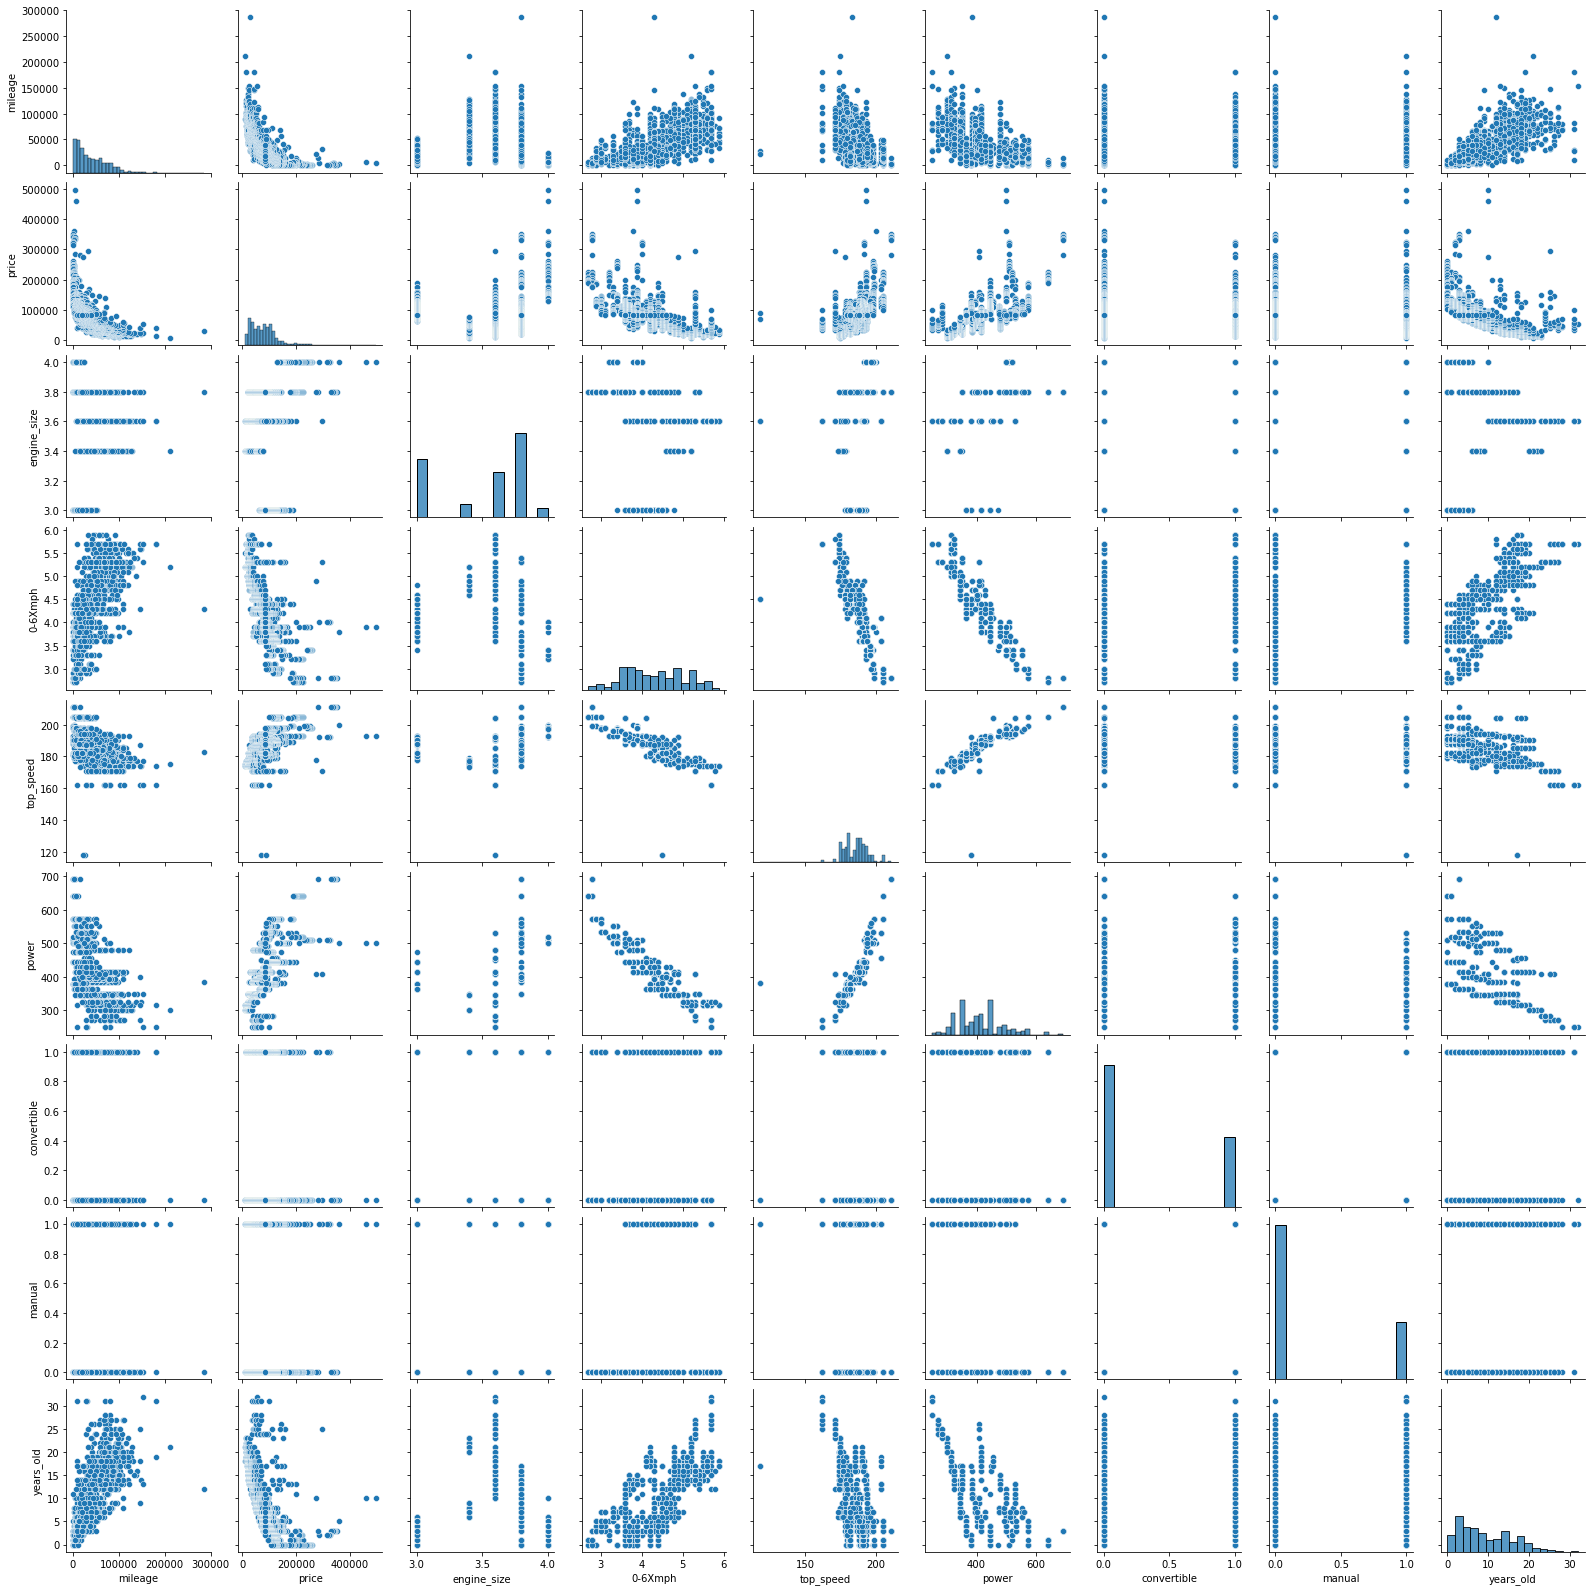

In [87]:
sns.pairplot(numerics_df)

In [88]:
def vifs(df):
    vif = pd.DataFrame()
    vif['variables'] = df.columns
    vif['vif'] =[variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    print(vif)

In [89]:
def simple_lr(y, X):
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    print(results.summary())
    return results

In [91]:
def plot_residuals(results):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
    fig.set_size_inches(26, 9)

    ax0.scatter(results.predict(), results.resid)
    ax0.set_ylabel('Residual')
    ax0.set_xlabel('Predicted price')
    ax0.set_title('Predicted target against residual')

    sns.distplot(results.resid, ax=ax1)
    sns.despine()
    ax1.set_xlabel('Residuals')
    ax1.set_title('Distribution of Residuals')

    stats.probplot(results.resid, dist="norm", plot=ax2)
    ax2.set_title("Normal Q-Q plot")
    ax2.set_xlabel("Theoretical Quantiles")
    ax2.set_ylabel("Ordered Values")

    fig.suptitle("Plotting residuals", size=16)

In [93]:
def cv_lr(y, X):
    kf = KFold(n_splits=5, shuffle=True)

    r2s, rmses, maes = [], [], []
    for train_ind, val_ind in kf.split(X,y):
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        r2s.append(lm.score(X_val, y_val))
        rmses.append(mean_squared_error(y_val, lm.predict(X_val), squared=False))
        maes.append(mean_absolute_error(y_val, lm.predict(X_val)))

    print(f'\n\nMean cv r^2: {np.mean(r2s):.3f} +- {np.std(r2s):.3f}')
    print(f'Mean cv RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')
    print(f'Mean cv MAE: {np.mean(maes):.3f} +- {np.std(maes):.3f}')

In [94]:
def evaluate(y, X):
    vifs(X)
    results = simple_lr(y, X)
    plot_residuals(results)
    cv_lr(y, X)

In [95]:
X = numerics_df.drop("price", axis=1)
y = numerics_df.loc[:, "price"]
y.head()

202109207563077    116900.0
202109227674550     15995.0
202108136210396     15995.0
202106043455421     15995.0
202105082360787     15995.0
Name: price, dtype: float64

In [96]:
X_non_test, X_test, y_non_test, y_test = train_test_split(X, y, test_size=.2)

     variables         vif
0      mileage    6.254027
1  engine_size  194.318502
2      0-6Xmph  240.671964
3    top_speed  796.037000
4        power  354.885254
5  convertible    1.627322
6       manual    1.756545
7    years_old   12.344148
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     318.5
Date:                Tue, 09 Nov 2021   Prob (F-statistic):          3.19e-294
Time:                        15:44:52   Log-Likelihood:                -14632.
No. Observations:                1248   AIC:                         2.928e+04
Df Residuals:                    1239   BIC:                         2.933e+04
Df Model:                           8                                         
Covariance Type:            nonrobust         

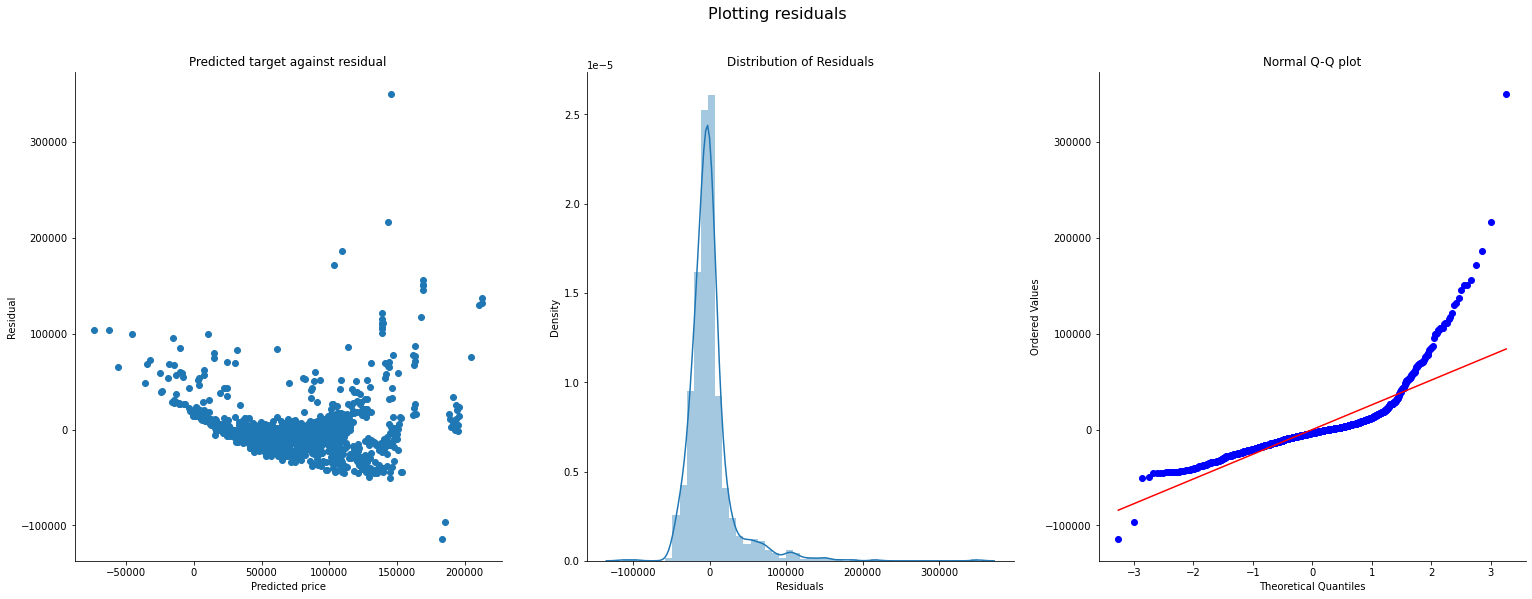

In [97]:
evaluate(y_non_test, X_non_test)

     variables        vif
0      mileage   6.181054
1      0-6Xmph  29.492420
2        power  13.837627
3  convertible   1.536624
4       manual   1.729271
5    years_old  10.304689
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     402.3
Date:                Tue, 09 Nov 2021   Prob (F-statistic):          7.19e-287
Time:                        15:44:53   Log-Likelihood:                -14655.
No. Observations:                1248   AIC:                         2.932e+04
Df Residuals:                    1241   BIC:                         2.936e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    st

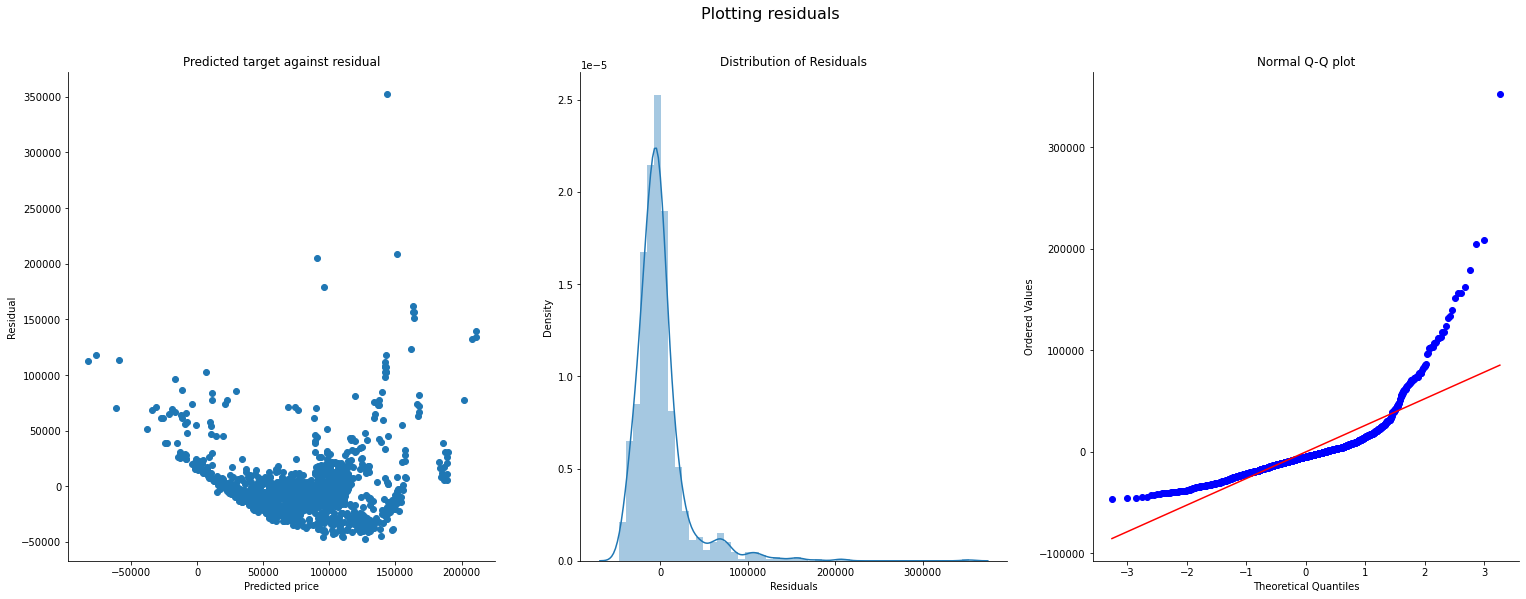

In [98]:
X_non_test_2 = X_non_test.drop(columns=['top_speed', 'engine_size'])

evaluate(y_non_test, X_non_test_2)

     variables       vif
0      mileage  2.194234
1        power  2.302240
2  convertible  1.467480
3       manual  1.484220
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     561.8
Date:                Tue, 09 Nov 2021   Prob (F-statistic):          8.66e-277
Time:                        15:44:54   Log-Likelihood:                -14685.
No. Observations:                1248   AIC:                         2.938e+04
Df Residuals:                    1243   BIC:                         2.941e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----

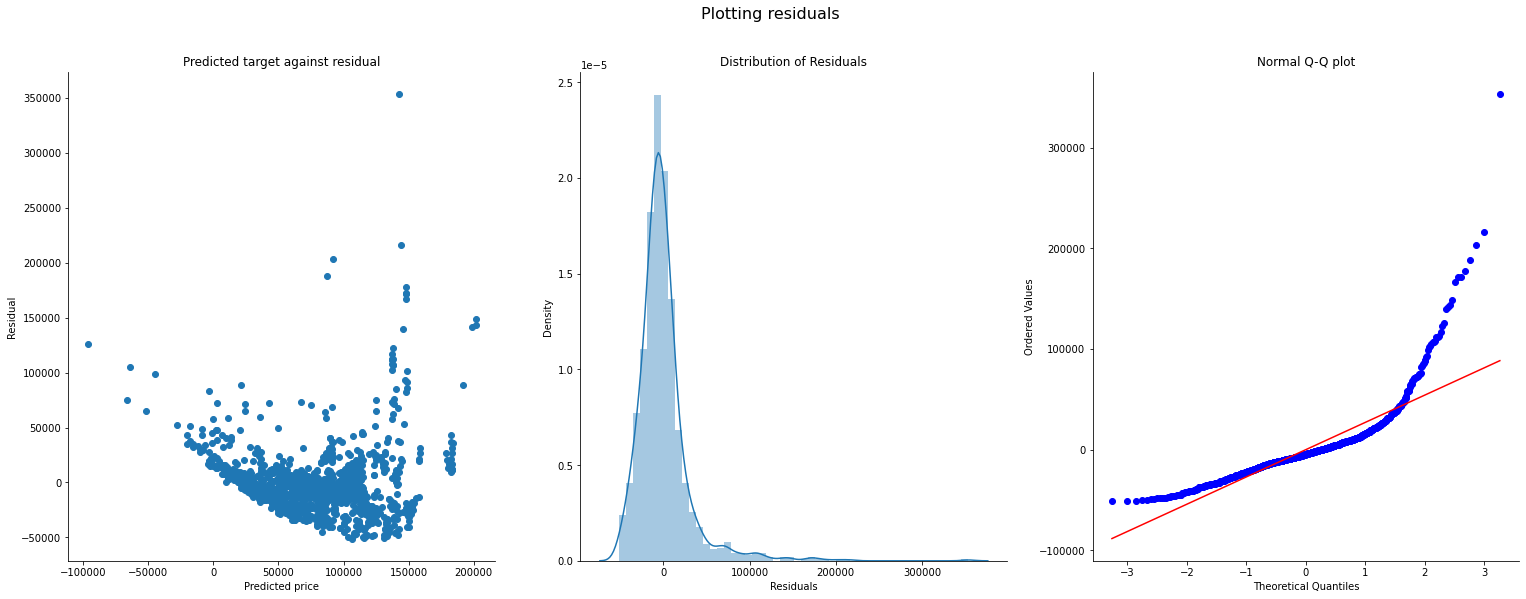

In [99]:
X_non_test_3 = X_non_test_2.drop(columns=['0-6Xmph', 'years_old'])

evaluate(y_non_test, X_non_test_3)

          variables       vif
0             power  3.959896
1       convertible  1.480303
2            manual  1.731119
3         years_old  3.424844
4  mileage per year  4.090945
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     504.2
Date:                Tue, 09 Nov 2021   Prob (F-statistic):          6.96e-296
Time:                        15:44:55   Log-Likelihood:                -14638.
No. Observations:                1248   AIC:                         2.929e+04
Df Residuals:                    1242   BIC:                         2.932e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef   

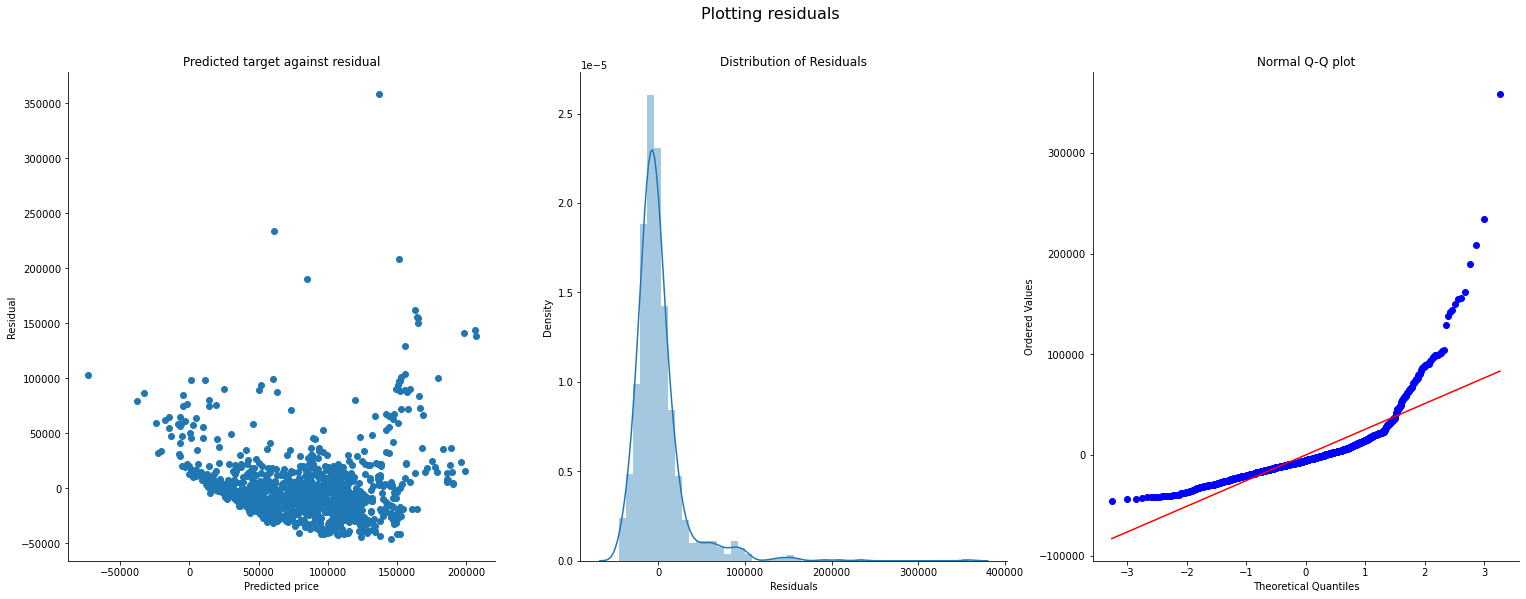

In [100]:
X_non_test_4 = X_non_test_2.drop(columns=['0-6Xmph', 'mileage'])
X_non_test_4['mileage per year'] = X_non_test['mileage'] / (X_non_test['years_old'] + 1)

evaluate(y_non_test, X_non_test_4)

          variables       vif
0             power  3.657322
1            manual  1.724586
2         years_old  3.379422
3  mileage per year  4.090699
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     630.7
Date:                Tue, 09 Nov 2021   Prob (F-statistic):          2.71e-297
Time:                        15:44:56   Log-Likelihood:                -14638.
No. Observations:                1248   AIC:                         2.929e+04
Df Residuals:                    1243   BIC:                         2.931e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|

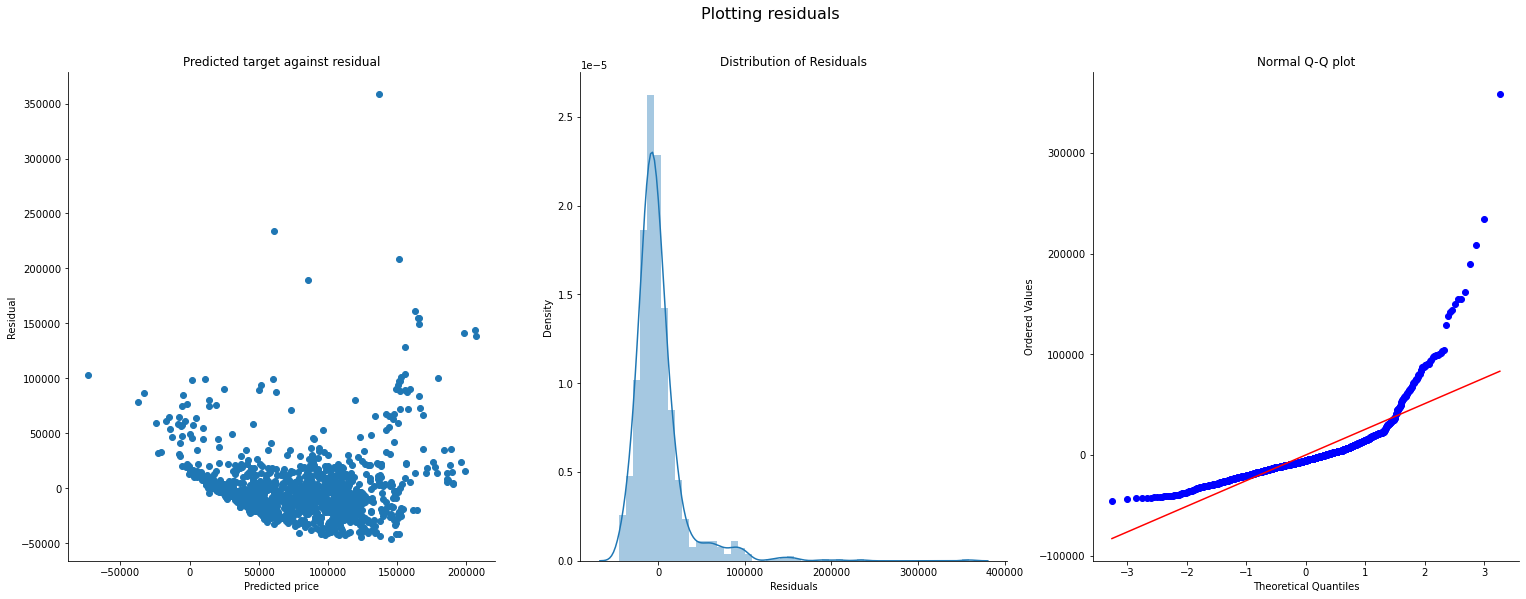

In [101]:
X_non_test_5 = X_non_test_4.drop('convertible', axis=1)

evaluate(y_non_test, X_non_test_5)

          variables        vif
0             power  14.479866
1            manual   1.741381
2         years_old   6.209469
3  mileage per year   4.768902
4   max_mph_per_bhp  30.875319
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     521.8
Date:                Tue, 09 Nov 2021   Prob (F-statistic):          4.29e-302
Time:                        15:44:57   Log-Likelihood:                -14623.
No. Observations:                1248   AIC:                         2.926e+04
Df Residuals:                    1242   BIC:                         2.929e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       c

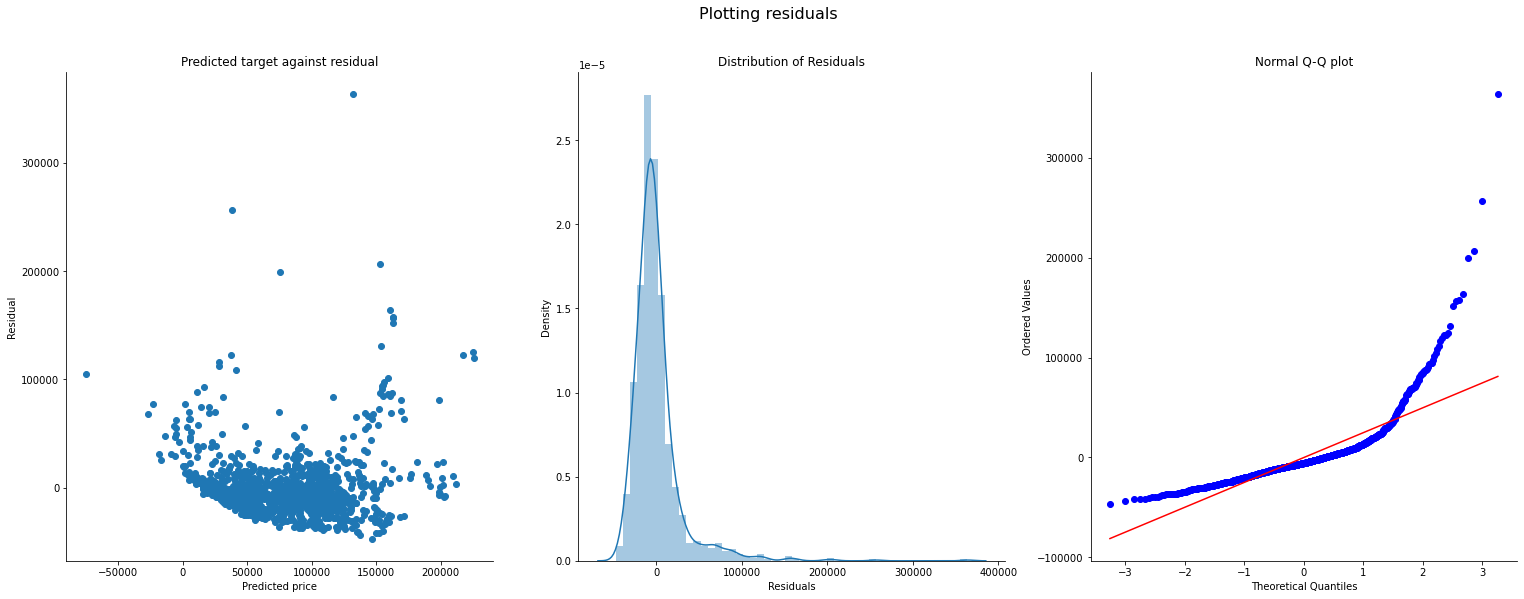

In [102]:
X_non_test_6 = X_non_test_5.copy()
X_non_test_6['max_mph_per_bhp'] = X_non_test['top_speed'] / X_non_test['power']

evaluate(y_non_test, X_non_test_6)

          variables        vif
0             power  14.479866
1            manual   1.741381
2         years_old   6.209469
3  mileage per year   4.768902
4   max_mph_per_bhp  30.875319
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     930.5
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:44:57   Log-Likelihood:                -272.19
No. Observations:                1248   AIC:                             556.4
Df Residuals:                    1242   BIC:                             587.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       c

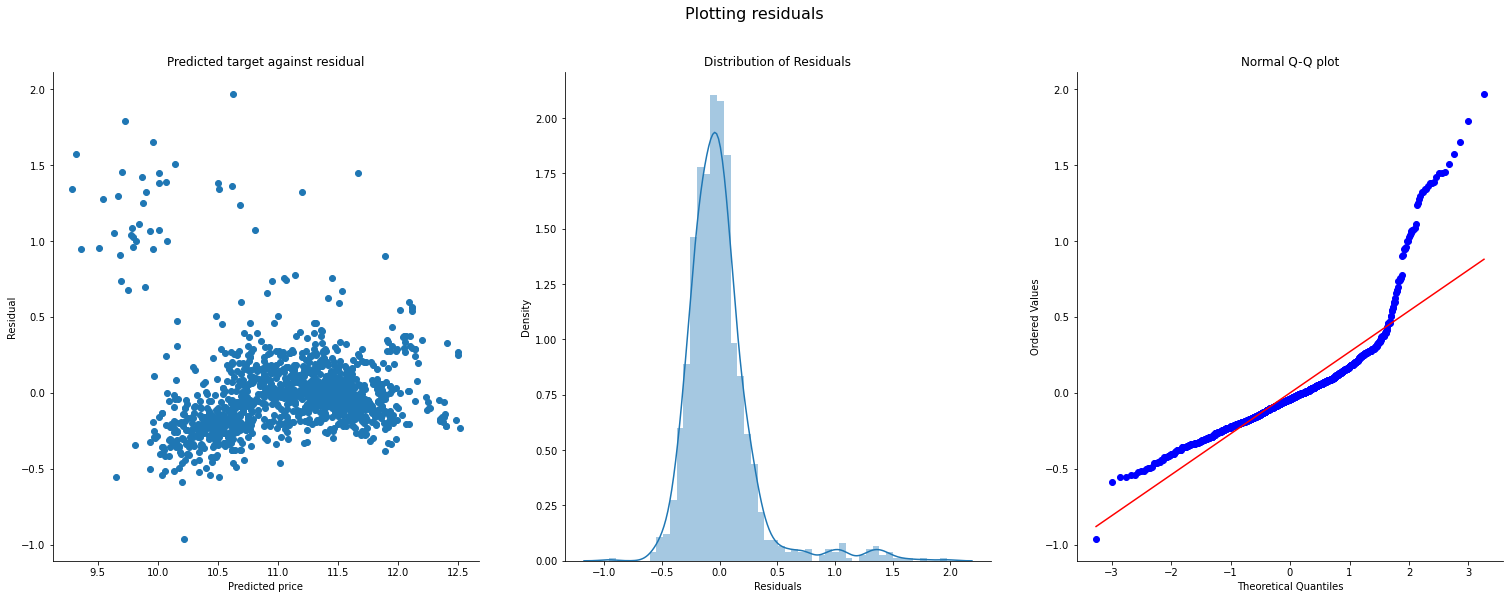

In [103]:
log_y = np.log(y_non_test)

evaluate(log_y, X_non_test_6)

In [104]:
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_non_test_5)

poly_non_test_5_df = pd.DataFrame(X_train_poly, columns = poly.get_feature_names(X_non_test_5.columns), index=X_non_test_5.index)

In [105]:
poly_non_test_5_df.to_pickle("./poly_non_test_5_df.pkl")
y_non_test.to_pickle("./y_non_test.pkl")

poly_non_test_5_df.head()

,1,power,manual,years_old,mileage per year,power^2,power manual,power years_old,power mileage per year,manual^2,manual years_old,manual mileage per year,years_old^2,years_old mileage per year,mileage per year^2
202106224112829,1.0,325.0,1.0,15.0,4921.375000,105625.0,325.0,4875.0,1.599447e+06,1.0,15.0,4921.375000,225.0,73820.625000,2.421993e+07
202110148485474,1.0,350.0,1.0,15.0,1860.312500,122500.0,350.0,5250.0,6.511094e+05,1.0,15.0,1860.312500,225.0,27904.687500,3.460763e+06
202108246593754,1.0,250.0,1.0,31.0,2545.093750,62500.0,250.0,7750.0,6.362734e+05,1.0,31.0,2545.093750,961.0,78897.906250,6.477502e+06
202108236550132,1.0,365.0,1.0,3.0,4750.000000,133225.0,365.0,1095.0,1.733750e+06,1.0,3.0,4750.000000,9.0,14250.000000,2.256250e+07
202110268901845,1.0,365.0,1.0,5.0,3666.666667,133225.0,365.0,1825.0,1.338333e+06,1.0,5.0,3666.666667,25.0,18333.333333,1.344444e+07


                     variables          vif
0                            1  4626.077664
1                        power   385.614106
2                       manual          inf
3                    years_old   302.945106
4             mileage per year    93.964184
5                      power^2   260.097477
6                 power manual    81.282001
7              power years_old   110.271361
8       power mileage per year    60.929210
9                     manual^2          inf
10            manual years_old    14.146099
11     manual mileage per year     7.500902
12                 years_old^2    33.370621
13  years_old mileage per year    14.609388
14          mileage per year^2     5.456252
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:       

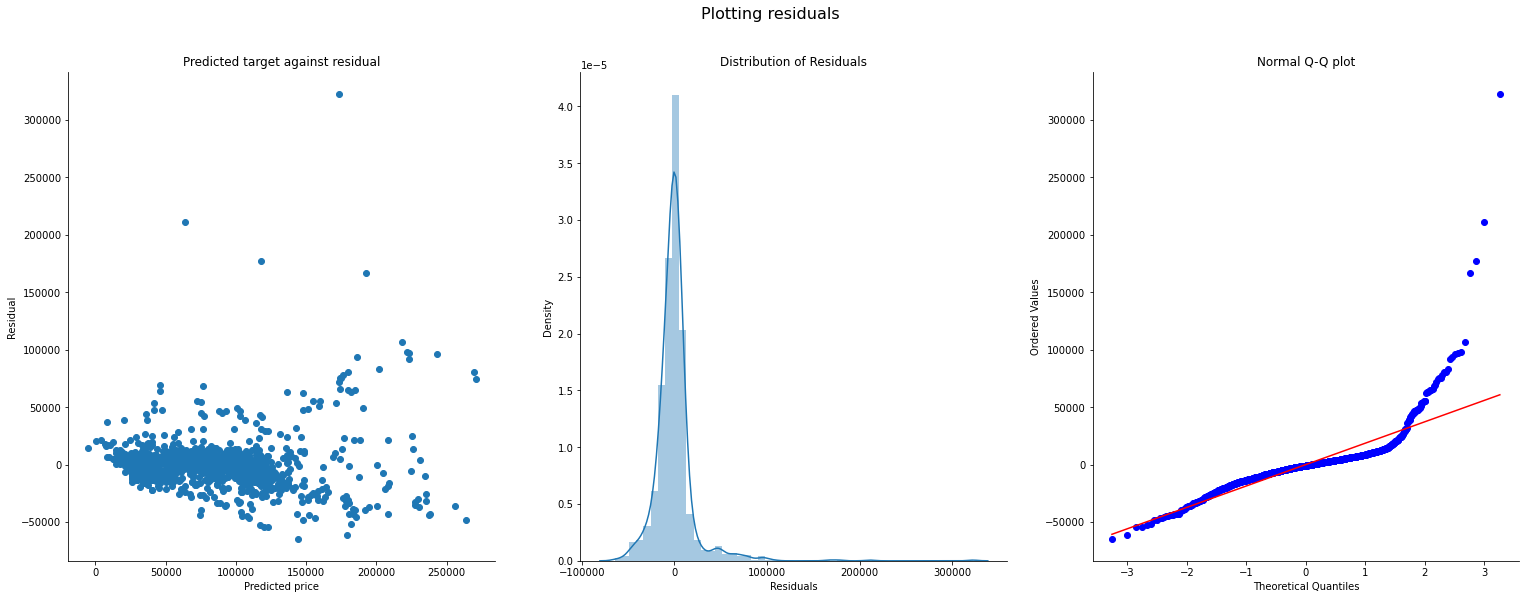

In [106]:
evaluate(y_non_test, poly_non_test_5_df)

In [107]:
X_train_poly_6 = poly.fit_transform(X_non_test_6)

poly_non_test_6_df = pd.DataFrame(X_train_poly_6, columns = poly.get_feature_names(X_non_test_6.columns), index=X_non_test_6.index)

poly_non_test_6_df.to_pickle("./poly_non_test_6_df.pkl")
poly_non_test_6_df.head()

,1,power,manual,years_old,mileage per year,max_mph_per_bhp,power^2,power manual,power years_old,power mileage per year,...,manual^2,manual years_old,manual mileage per year,manual max_mph_per_bhp,years_old^2,years_old mileage per year,years_old max_mph_per_bhp,mileage per year^2,mileage per year max_mph_per_bhp,max_mph_per_bhp^2
202106224112829,1.0,325.0,1.0,15.0,4921.375000,0.544615,105625.0,325.0,4875.0,1.599447e+06,...,1.0,15.0,4921.375000,0.544615,225.0,73820.625000,8.169231,2.421993e+07,2680.256538,0.296606
202110148485474,1.0,350.0,1.0,15.0,1860.312500,0.520000,122500.0,350.0,5250.0,6.511094e+05,...,1.0,15.0,1860.312500,0.520000,225.0,27904.687500,7.800000,3.460763e+06,967.362500,0.270400
202108246593754,1.0,250.0,1.0,31.0,2545.093750,0.648000,62500.0,250.0,7750.0,6.362734e+05,...,1.0,31.0,2545.093750,0.648000,961.0,78897.906250,20.088000,6.477502e+06,1649.220750,0.419904
202108236550132,1.0,365.0,1.0,3.0,4750.000000,0.501370,133225.0,365.0,1095.0,1.733750e+06,...,1.0,3.0,4750.000000,0.501370,9.0,14250.000000,1.504110,2.256250e+07,2381.506849,0.251372
202110268901845,1.0,365.0,1.0,5.0,3666.666667,0.495890,133225.0,365.0,1825.0,1.338333e+06,...,1.0,5.0,3666.666667,0.495890,25.0,18333.333333,2.479452,1.344444e+07,1818.264840,0.245907


                           variables           vif
0                                  1  9.260148e+05
1                              power  2.959753e+04
2                             manual           inf
3                          years_old  1.164183e+04
4                   mileage per year  6.901165e+03
5                    max_mph_per_bhp  2.222732e+04
6                            power^2  7.131502e+03
7                       power manual  1.575492e+03
8                    power years_old  1.339780e+03
9             power mileage per year  1.102073e+03
10             power max_mph_per_bhp  5.539484e+02
11                          manual^2           inf
12                  manual years_old  1.800225e+01
13           manual mileage per year  8.272182e+00
14            manual max_mph_per_bhp  3.555588e+03
15                       years_old^2  4.238807e+01
16        years_old mileage per year  2.106733e+01
17         years_old max_mph_per_bhp  6.521750e+03
18                mileage per y

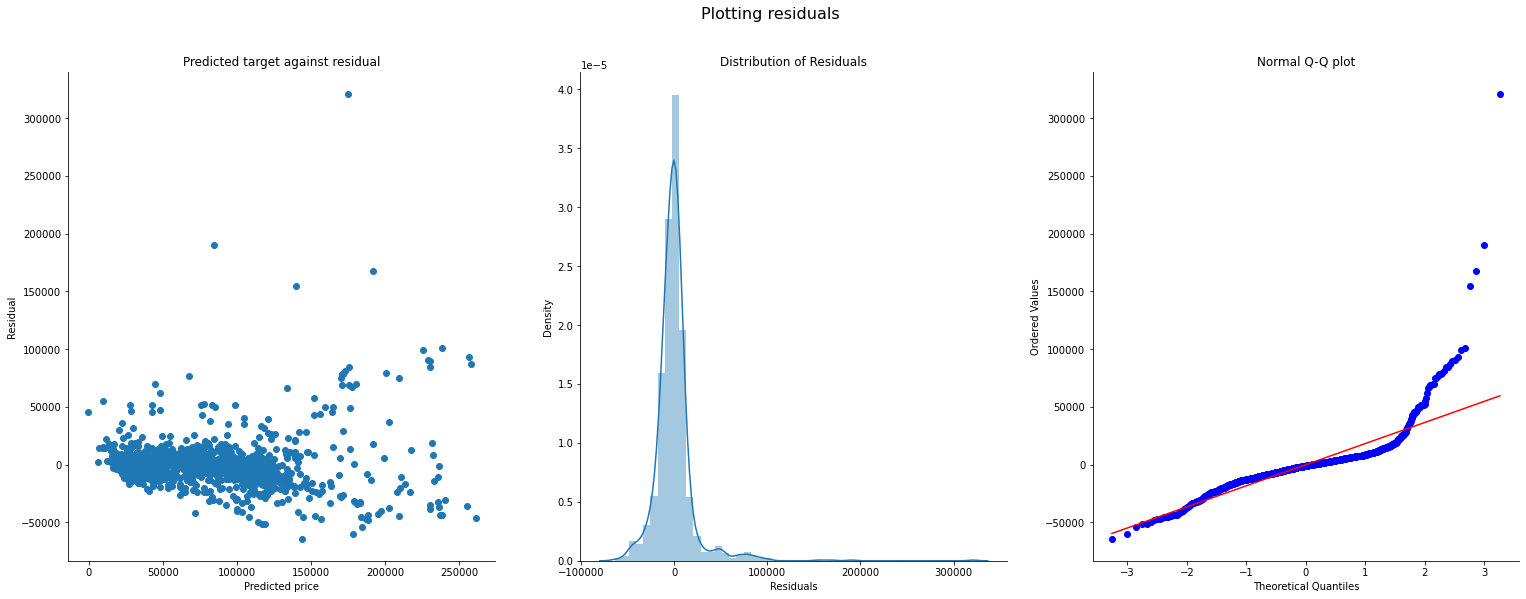

In [108]:
evaluate(y_non_test, poly_non_test_6_df)

In [109]:
poly_3 = PolynomialFeatures(degree=3)

# Fit polynomial features and transform on training data
X_train_poly_3 = poly_3.fit_transform(X_non_test_5)

poly_3_df = pd.DataFrame(X_train_poly_3, columns = poly_3.get_feature_names(X_non_test_5.columns), index=X_non_test_5.index)
poly_3_df.head()

,1,power,manual,years_old,mileage per year,power^2,power manual,power years_old,power mileage per year,manual^2,...,manual^3,manual^2 years_old,manual^2 mileage per year,manual years_old^2,manual years_old mileage per year,manual mileage per year^2,years_old^3,years_old^2 mileage per year,years_old mileage per year^2,mileage per year^3
202106224112829,1.0,325.0,1.0,15.0,4921.375000,105625.0,325.0,4875.0,1.599447e+06,1.0,...,1.0,15.0,4921.375000,225.0,73820.625000,2.421993e+07,3375.0,1.107309e+06,3.632990e+08,1.191954e+11
202110148485474,1.0,350.0,1.0,15.0,1860.312500,122500.0,350.0,5250.0,6.511094e+05,1.0,...,1.0,15.0,1860.312500,225.0,27904.687500,3.460763e+06,3375.0,4.185703e+05,5.191144e+07,6.438100e+09
202108246593754,1.0,250.0,1.0,31.0,2545.093750,62500.0,250.0,7750.0,6.362734e+05,1.0,...,1.0,31.0,2545.093750,961.0,78897.906250,6.477502e+06,29791.0,2.445835e+06,2.008026e+08,1.648585e+10
202108236550132,1.0,365.0,1.0,3.0,4750.000000,133225.0,365.0,1095.0,1.733750e+06,1.0,...,1.0,3.0,4750.000000,9.0,14250.000000,2.256250e+07,27.0,4.275000e+04,6.768750e+07,1.071719e+11
202110268901845,1.0,365.0,1.0,5.0,3666.666667,133225.0,365.0,1825.0,1.338333e+06,1.0,...,1.0,5.0,3666.666667,25.0,18333.333333,1.344444e+07,125.0,9.166667e+04,6.722222e+07,4.929630e+10


                            variables           vif
0                                   1  0.000000e+00
1                               power  3.366463e+04
2                              manual  2.124339e+13
3                           years_old  2.927299e+04
4                    mileage per year  7.021001e+03
5                             power^2  9.179882e+04
6                        power manual  1.501200e+15
7                     power years_old  4.431125e+04
8              power mileage per year  1.513706e+04
9                            manual^2  1.396106e+10
10                   manual years_old  1.286743e+15
11            manual mileage per year           inf
12                        years_old^2  1.051569e+04
13         years_old mileage per year  2.771551e+03
14                 mileage per year^2  1.652222e+03
15                            power^3  1.684064e+04
16                     power^2 manual  4.678002e+03
17                  power^2 years_old  5.703081e+03
18          

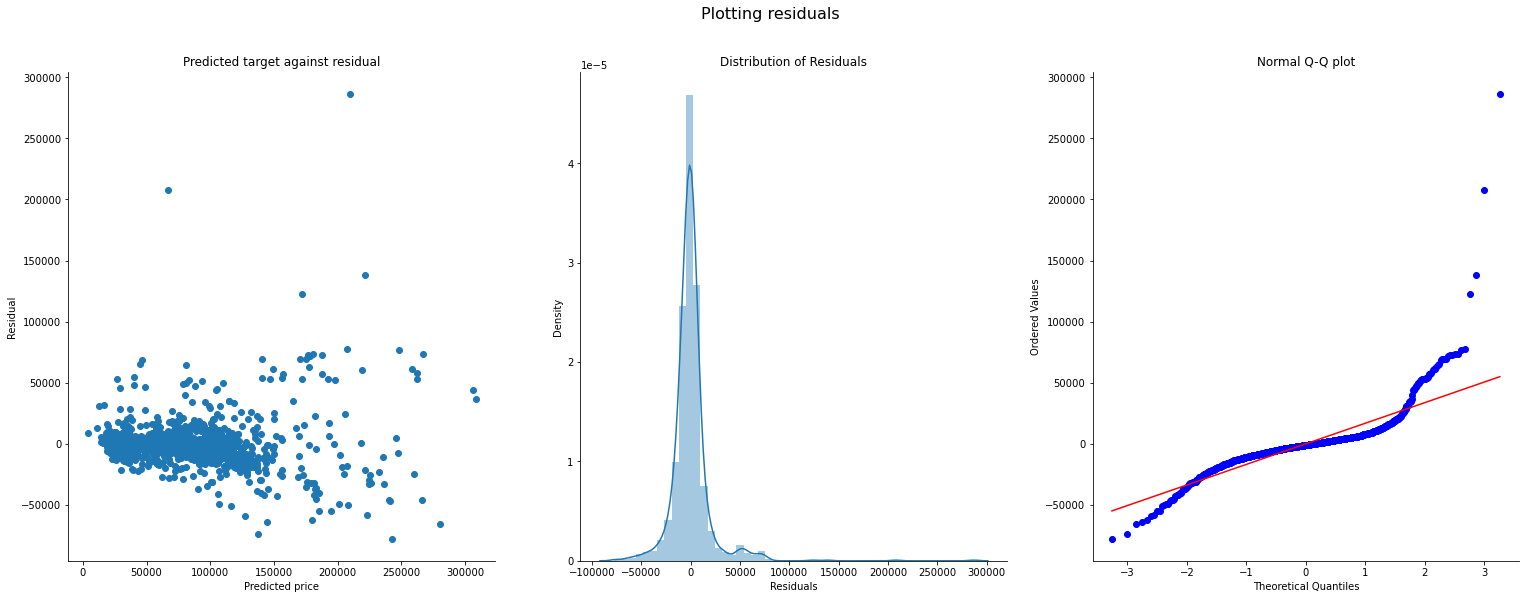

In [110]:
evaluate(y_non_test, poly_3_df)

                           variables           vif
0                                  1  9.260148e+05
1                              power  2.959753e+04
2                             manual           inf
3                          years_old  1.164183e+04
4                   mileage per year  6.901165e+03
5                    max_mph_per_bhp  2.222732e+04
6                            power^2  7.131502e+03
7                       power manual  1.575492e+03
8                    power years_old  1.339780e+03
9             power mileage per year  1.102073e+03
10             power max_mph_per_bhp  5.539484e+02
11                          manual^2           inf
12                  manual years_old  1.800225e+01
13           manual mileage per year  8.272182e+00
14            manual max_mph_per_bhp  3.555588e+03
15                       years_old^2  4.238807e+01
16        years_old mileage per year  2.106733e+01
17         years_old max_mph_per_bhp  6.521750e+03
18                mileage per y

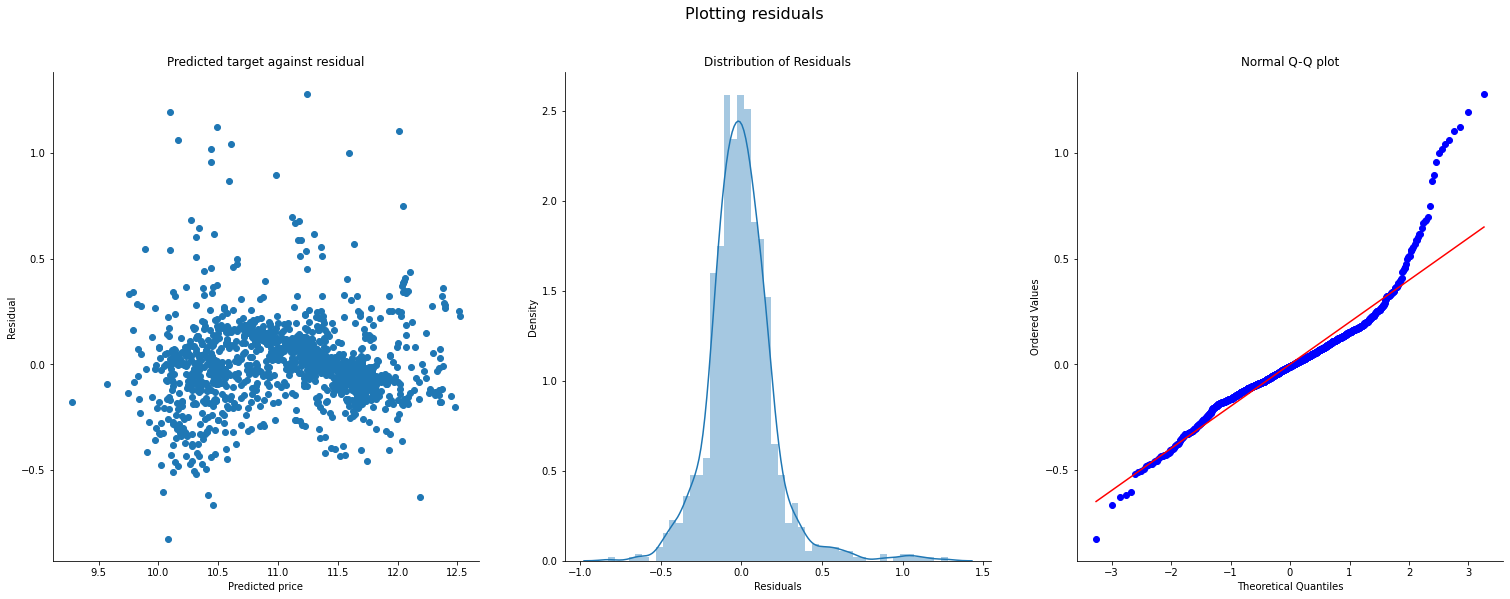

In [111]:
evaluate(log_y, poly_non_test_6_df)

In [112]:
X_train_poly_5, X_val_poly_5, y_train_poly_5, y_val_poly_5 = train_test_split(poly_non_test_5_df, y_non_test, test_size=.25)

In [113]:
X_train_poly_6, X_val_poly_6, y_train_poly_6, y_val_poly_6 = train_test_split(poly_non_test_6_df, y_non_test, test_size=.25)

In [114]:
log_y_train = np.log(y_train_poly_5)
results = simple_lr(log_y_train, X_train_poly_5)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     629.9
Date:                Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:45:02   Log-Likelihood:                 137.72
No. Observations:                 936   AIC:                            -247.4
Df Residuals:                     922   BIC:                            -179.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
1                   

In [115]:
mae = sum(abs(np.exp(results.predict(X_val_poly_5)) - y_val_poly_5))/len(y_val_poly_5)
mae

12944.840682832868

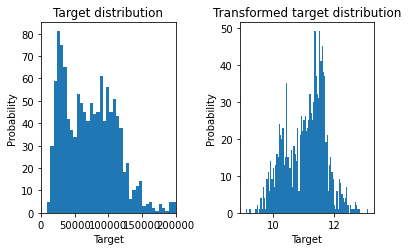

In [116]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y_non_test, bins=100)
ax0.set_xlim([0, 200000])
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(log_y, bins=100)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

In [117]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score

regr_trans = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1
)

regr_trans.fit(X_train_poly_5, y_train_poly_5)
y_pred = regr_trans.predict(X_val_poly_5)

In [118]:
r2_score(y_val_poly_5, y_pred)

0.7988343006311086

In [119]:
median_absolute_error(y_val_poly_5, y_pred)

6539.924664315642

In [120]:
mean_absolute_error(y_val_poly_5, y_pred)

12944.7978939945

In [121]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform

y_trans = quantile_transform(
    y_non_test.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

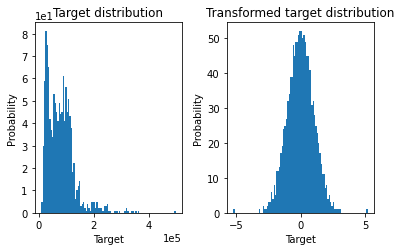

In [262]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y_non_test, bins=100)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")
ax0.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1.hist(y_trans, bins=100)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

In [258]:
from sklearn.preprocessing import power_transform

y_trans_power = power_transform(
    y_non_test.to_frame(), method='box-cox', copy=True
).squeeze()

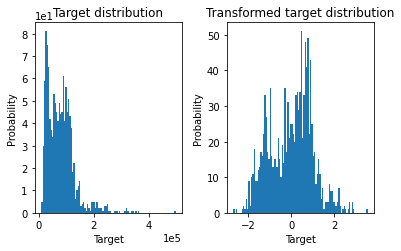

In [263]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y_non_test, bins=100)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")
ax0.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1.hist(y_trans_power, bins=100)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

In [124]:
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(X_non_test_5, y_non_test, test_size=.25)

In [125]:
regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
)
regr_trans.fit(X_train_5, y_train_5)
y_pred_5 = regr_trans.predict(X_val_5)

In [126]:
r2_score(y_val_5, y_pred_5)

0.6393392805669555

In [127]:
median_absolute_error(y_val_5, y_pred_5)

6924.387599506583

In [128]:
mean_absolute_error(y_val_5, y_pred_5)

15278.542888317239

<AxesSubplot:xlabel='price'>

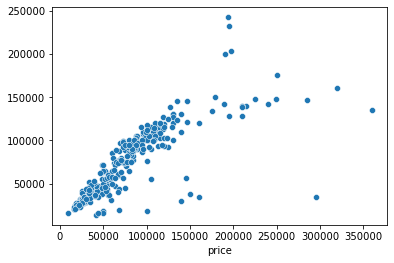

In [129]:
sns.scatterplot(x=y_val_5, y=y_pred_5)

Text(0.5, 0, 'predicted price')

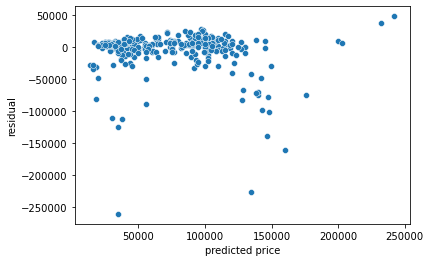

In [266]:
fig = sns.scatterplot(x=y_pred_5, y=(y_pred_5-y_val_5))
fig.set_ylabel("residual")
fig.set_xlabel("predicted price")

Text(0.5, 1.0, 'Distribution of Residuals')

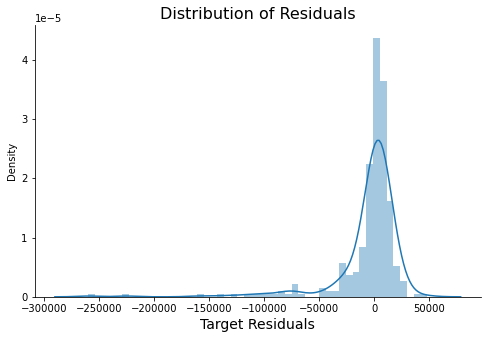

In [131]:
plt.figure(figsize=(8, 5))
sns.distplot((y_pred_5-y_val_5))
plt.xlabel('Target Residuals', size=14)
sns.despine()
plt.title('Distribution of Residuals', size=16)

In [133]:
regr_trans = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
)
regr_trans.fit(X_train_poly_5, y_train_poly_5)
y_pred_Q = regr_trans.predict(X_val_poly_5)

In [134]:
r2_score(y_val_poly_5, y_pred_Q)

0.792703628019409

In [135]:
median_absolute_error(y_val_poly_5, y_pred_Q)

6524.314028247991

In [136]:
mean_absolute_error(y_val_poly_5, y_pred_Q)

13189.961171385634

<AxesSubplot:xlabel='price'>

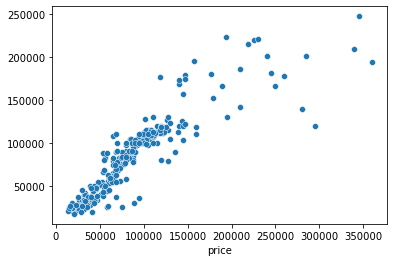

In [137]:
sns.scatterplot(x=y_val_poly_5, y=y_pred_Q)

<AxesSubplot:xlabel='price'>

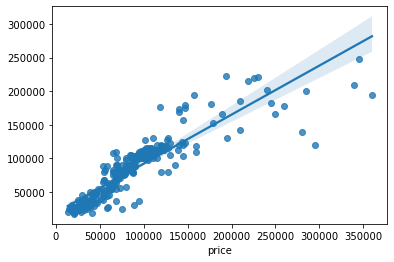

In [138]:
sns.regplot(x=y_val_poly_5, y=y_pred_Q)

<AxesSubplot:ylabel='price'>

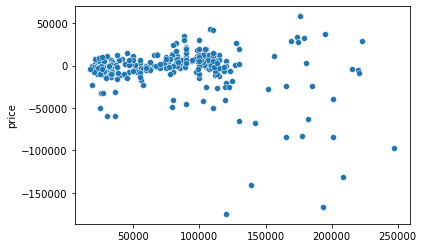

In [139]:
sns.scatterplot(x=y_pred_Q, y=(y_pred_Q-y_val_poly_5))

((array([-2.84520254, -2.54998829, -2.38293086, -2.26393382, -2.17034194,
         -2.09261297, -2.0257883 , -1.96694762, -1.91422028, -1.86633306,
         -1.82237868, -1.78168684, -1.74374778, -1.70816438, -1.67462102,
         -1.64286254, -1.61267956, -1.5838981 , -1.55637193, -1.52997692,
         -1.50460676, -1.48016967, -1.45658584, -1.43378542, -1.41170693,
         -1.39029592, -1.36950394, -1.34928772, -1.32960838, -1.31043091,
         -1.29172364, -1.27345781, -1.25560726, -1.23814806, -1.22105834,
         -1.20431799, -1.18790849, -1.17181278, -1.15601506, -1.1405007 ,
         -1.1252561 , -1.11026861, -1.09552646, -1.08101863, -1.06673484,
         -1.05266543, -1.03880137, -1.02513416, -1.0116558 , -0.99835876,
         -0.98523595, -0.97228064, -0.9594865 , -0.94684752, -0.93435801,
         -0.92201257, -0.90980609, -0.89773368, -0.88579071, -0.87397277,
         -0.86227565, -0.85069534, -0.839228  , -0.82786997, -0.81661774,
         -0.80546798, -0.79441746, -0.

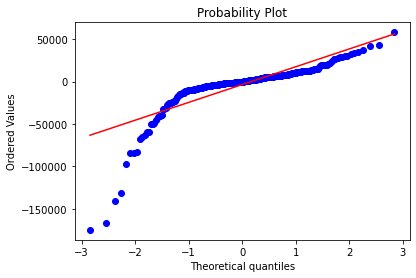

In [140]:
stats.probplot(y_pred_Q-y_val_poly_5, dist="norm", plot=plt)

Text(0.5, 1.0, 'Distribution of Residuals')

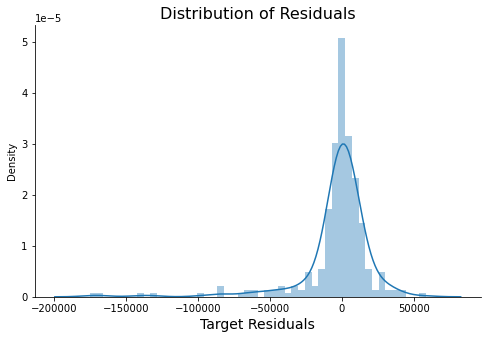

In [141]:
plt.figure(figsize=(8, 5))
sns.distplot((y_pred_Q-y_val_poly_5))
plt.xlabel('Target Residuals', size=14)
sns.despine()
plt.title('Distribution of Residuals', size=16)

In [142]:
regr_trans = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
)
regr_trans.fit(X_train_poly_6, y_train_poly_6)
y_pred_Q = regr_trans.predict(X_val_poly_6)

In [143]:
r2_score(y_val_poly_6, y_pred_Q)

0.8046554912816715

In [144]:
mean_absolute_error(y_val_poly_6, y_pred_Q)

10457.053526182282

In [145]:
X_train_poly_2 = poly.fit_transform(X_non_test)

poly_non_test_df = pd.DataFrame(X_train_poly_2, columns = poly.get_feature_names(X_non_test.columns), index=X_non_test.index)

poly_non_test_df.to_pickle(("./poly_non_test_df.pkl"))

In [200]:
X_test_poly_2 = poly.fit_transform(X_test)

poly_test_df = pd.DataFrame(X_test_poly_2, columns = poly.get_feature_names(X_test.columns), index=X_test.index)

In [146]:
vifs(poly_non_test_df)

                  variables           vif
0                         1  0.000000e+00
1                   mileage  1.826602e+04
2               engine_size  3.652901e+04
3                   0-6Xmph  1.316327e+05
4                 top_speed  1.492249e+04
5                     power  8.441111e+04
6               convertible           inf
7                    manual           inf
8                 years_old  3.482383e+04
9                 mileage^2  1.022903e+01
10      mileage engine_size  1.427353e+03
11          mileage 0-6Xmph  1.497212e+03
12        mileage top_speed  1.863499e+04
13            mileage power  1.142132e+03
14      mileage convertible  9.781443e+00
15           mileage manual  1.675022e+01
16        mileage years_old  1.099627e+02
17            engine_size^2  1.005184e+04
18      engine_size 0-6Xmph  9.175838e+03
19    engine_size top_speed  4.024743e+04
20        engine_size power  2.301184e+04
21  engine_size convertible  3.982230e+02
22       engine_size manual  5.372

In [229]:
def cv_regression(X, y, regr):
    kf = KFold(n_splits=10, shuffle=True)

    train_r2s, train_rmses, train_maes = [], [], []
    r2s, rmses, maes = [], [], []
    for train_ind, val_ind in kf.split(X,y):
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        regr.fit(X_train, y_train)

        train_r2s.append(regr.score(X_train, y_train))
        train_rmses.append(mean_squared_error(y_train, regr.predict(X_train), squared=False))
        train_maes.append(mean_absolute_error(y_train, regr.predict(X_train)))

        r2s.append(regr.score(X_val, y_val))
        rmses.append(mean_squared_error(y_val, regr.predict(X_val), squared=False))
        maes.append(mean_absolute_error(y_val, regr.predict(X_val)))

    print(f'\n\nMean train cv r^2: {np.mean(train_r2s):.3f} +- {np.std(train_r2s):.3f}')
    print(f'Mean train cv RMSE: {np.mean(train_rmses):.3f} +- {np.std(train_rmses):.3f}')
    print(f'Mean train cv MAE: {np.mean(train_maes):.3f} +- {np.std(train_maes):.3f}')

    print(f'\n\nMean val cv r^2: {np.mean(r2s):.3f} +- {np.std(r2s):.3f}')
    print(f'Mean val cv RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')
    print(f'Mean val cv MAE: {np.mean(maes):.3f} +- {np.std(maes):.3f}')

    return regr

In [242]:
regr = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=PowerTransformer(method='box-cox'),
)

regressor = cv_regression(poly_non_test_df, y_non_test, regr)
regressor



Mean train cv r^2: 0.889 +- 0.009
Mean train cv RMSE: 17441.615 +- 863.561
Mean train cv MAE: 8176.253 +- 114.221


Mean val cv r^2: 0.884 +- 0.067
Mean val cv RMSE: 17185.121 +- 7007.148
Mean val cv MAE: 8579.944 +- 1183.115


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=PowerTransformer(method='box-cox'))

In [243]:
y_test_pred = regressor.predict(poly_test_df)

mean_absolute_error(y_test, y_test_pred)

7813.629884401572

In [244]:
regressor.score(poly_test_df, y_test)

0.8534602342849077

Text(0.5, 0, 'predicted price')

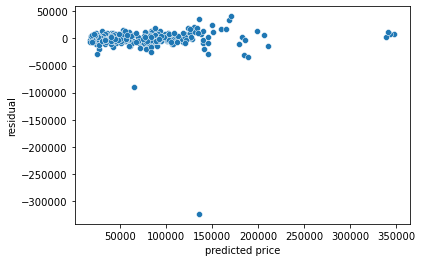

In [267]:
fig = sns.scatterplot(x=y_test_pred, y=(y_test_pred-y_test))
fig.set_ylabel("residual")
fig.set_xlabel("predicted price")

((array([-2.84520254, -2.54998829, -2.38293086, -2.26393382, -2.17034194,
         -2.09261297, -2.0257883 , -1.96694762, -1.91422028, -1.86633306,
         -1.82237868, -1.78168684, -1.74374778, -1.70816438, -1.67462102,
         -1.64286254, -1.61267956, -1.5838981 , -1.55637193, -1.52997692,
         -1.50460676, -1.48016967, -1.45658584, -1.43378542, -1.41170693,
         -1.39029592, -1.36950394, -1.34928772, -1.32960838, -1.31043091,
         -1.29172364, -1.27345781, -1.25560726, -1.23814806, -1.22105834,
         -1.20431799, -1.18790849, -1.17181278, -1.15601506, -1.1405007 ,
         -1.1252561 , -1.11026861, -1.09552646, -1.08101863, -1.06673484,
         -1.05266543, -1.03880137, -1.02513416, -1.0116558 , -0.99835876,
         -0.98523595, -0.97228064, -0.9594865 , -0.94684752, -0.93435801,
         -0.92201257, -0.90980609, -0.89773368, -0.88579071, -0.87397277,
         -0.86227565, -0.85069534, -0.839228  , -0.82786997, -0.81661774,
         -0.80546798, -0.79441746, -0.

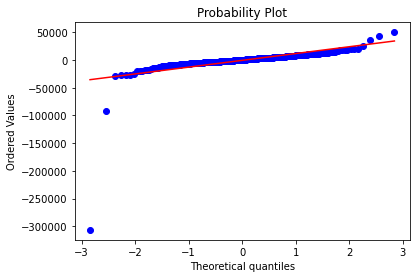

In [226]:
stats.probplot(y_test_pred-y_test, dist="norm", plot=plt)

In [ ]:
fig = sns.scatterplot(x=y_test, y=y_test_pred)
fig.set_ylabel("predicted price")
fig.set_xlabel("price")

In [235]:
cv_regression(poly_non_test_5_df, y_non_test, regr)



Mean train cv r^2: 0.819 +- 0.007
Mean train cv RMSE: 22225.732 +- 563.024
Mean train cv MAE: 11402.326 +- 65.525


Mean val cv r^2: 0.814 +- 0.059
Mean val cv RMSE: 22252.051 +- 4753.960
Mean val cv MAE: 11614.305 +- 739.368


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=PowerTransformer(method='box-cox'))

In [236]:
cv_regression(poly_non_test_6_df, y_non_test, regr)



Mean train cv r^2: 0.828 +- 0.011
Mean train cv RMSE: 21693.385 +- 961.115
Mean train cv MAE: 11110.132 +- 248.019


Mean val cv r^2: 0.824 +- 0.076
Mean val cv RMSE: 21591.057 +- 7347.701
Mean val cv MAE: 11471.661 +- 1944.452


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=PowerTransformer(method='box-cox'))

In [237]:
cv_regression(X_non_test_5, y_non_test, regr)



Mean train cv r^2: 0.738 +- 0.012
Mean train cv RMSE: 26751.507 +- 1012.315
Mean train cv MAE: 13912.018 +- 526.079


Mean val cv r^2: 0.748 +- 0.103
Mean val cv RMSE: 25630.117 +- 8739.915
Mean val cv MAE: 14069.268 +- 2784.528


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=PowerTransformer(method='box-cox'))

In [238]:
cv_regression(X_non_test, y_non_test, regr)



Mean train cv r^2: 0.721 +- 0.009
Mean train cv RMSE: 27611.229 +- 637.349
Mean train cv MAE: 13268.571 +- 244.518


Mean val cv r^2: 0.486 +- 0.712
Mean val cv RMSE: 33033.072 +- 18414.462
Mean val cv MAE: 14237.356 +- 3543.137


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=PowerTransformer(method='box-cox'))

In [245]:
regr2 = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
)

regressorQ = cv_regression(poly_non_test_df, y_non_test, regr2)



Mean train cv r^2: 0.880 +- 0.013
Mean train cv RMSE: 18089.869 +- 1076.247
Mean train cv MAE: 8867.710 +- 609.373


Mean val cv r^2: 0.865 +- 0.083
Mean val cv RMSE: 18509.014 +- 6815.605
Mean val cv MAE: 9461.939 +- 1160.398


In [246]:
y_test_pred_Q = regressorQ.predict(poly_test_df)

mean_absolute_error(y_test, y_test_pred_Q)

8543.750700336477

In [247]:
regressorQ.score(poly_test_df, y_test)

0.8542560131664676

((array([-2.84520254, -2.54998829, -2.38293086, -2.26393382, -2.17034194,
         -2.09261297, -2.0257883 , -1.96694762, -1.91422028, -1.86633306,
         -1.82237868, -1.78168684, -1.74374778, -1.70816438, -1.67462102,
         -1.64286254, -1.61267956, -1.5838981 , -1.55637193, -1.52997692,
         -1.50460676, -1.48016967, -1.45658584, -1.43378542, -1.41170693,
         -1.39029592, -1.36950394, -1.34928772, -1.32960838, -1.31043091,
         -1.29172364, -1.27345781, -1.25560726, -1.23814806, -1.22105834,
         -1.20431799, -1.18790849, -1.17181278, -1.15601506, -1.1405007 ,
         -1.1252561 , -1.11026861, -1.09552646, -1.08101863, -1.06673484,
         -1.05266543, -1.03880137, -1.02513416, -1.0116558 , -0.99835876,
         -0.98523595, -0.97228064, -0.9594865 , -0.94684752, -0.93435801,
         -0.92201257, -0.90980609, -0.89773368, -0.88579071, -0.87397277,
         -0.86227565, -0.85069534, -0.839228  , -0.82786997, -0.81661774,
         -0.80546798, -0.79441746, -0.

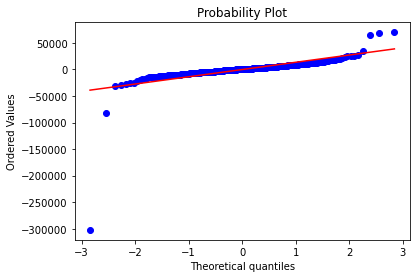

In [248]:
stats.probplot(y_test_pred_Q-y_test, dist="norm", plot=plt)

Text(0.5, 0, 'predicted price')

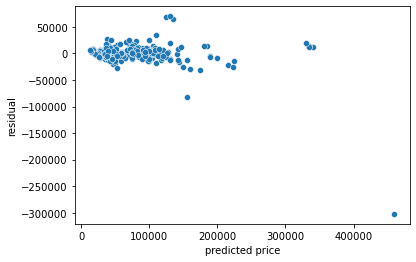

In [269]:
fig = sns.scatterplot(x=y_test, y=(y_test_pred_Q-y_test))
fig.set_ylabel("residual")
fig.set_xlabel("predicted price")

Text(0.5, 0, 'predicted price')

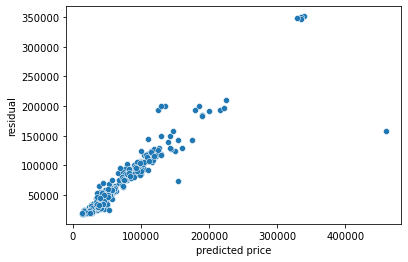

In [268]:
fig = sns.scatterplot(x=y_test, y=y_test_pred_Q)
fig.set_ylabel("predicted price")
fig.set_xlabel("price")

In [249]:
cv_regression(poly_non_test_5_df, y_non_test, regr2)



Mean train cv r^2: 0.821 +- 0.012
Mean train cv RMSE: 22099.066 +- 981.741
Mean train cv MAE: 11072.142 +- 146.312


Mean val cv r^2: 0.825 +- 0.083
Mean val cv RMSE: 21568.656 +- 6791.704
Mean val cv MAE: 11334.034 +- 1364.679


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=QuantileTransformer(n_quantiles=900,
                                                           output_distribution='normal'))

In [250]:
cv_regression(poly_non_test_6_df, y_non_test, regr2)



Mean train cv r^2: 0.821 +- 0.008
Mean train cv RMSE: 22121.046 +- 750.570
Mean train cv MAE: 10879.334 +- 141.577


Mean val cv r^2: 0.812 +- 0.050
Mean val cv RMSE: 22353.994 +- 5386.607
Mean val cv MAE: 11287.702 +- 775.910


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=QuantileTransformer(n_quantiles=900,
                                                           output_distribution='normal'))

In [251]:
cv_regression(X_non_test_5, y_non_test, regr2)



Mean train cv r^2: 0.727 +- 0.018
Mean train cv RMSE: 27306.343 +- 1163.998
Mean train cv MAE: 13923.067 +- 286.306


Mean val cv r^2: 0.739 +- 0.106
Mean val cv RMSE: 26203.054 +- 8200.896
Mean val cv MAE: 14051.835 +- 2231.477


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=QuantileTransformer(n_quantiles=900,
                                                           output_distribution='normal'))

In [252]:
cv_regression(X_non_test, y_non_test, regr2)



Mean train cv r^2: 0.706 +- 0.011
Mean train cv RMSE: 28339.441 +- 1061.498
Mean train cv MAE: 13978.691 +- 282.920


Mean val cv r^2: 0.713 +- 0.097
Mean val cv RMSE: 27600.216 +- 9054.321
Mean val cv MAE: 14241.824 +- 2395.260


TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=QuantileTransformer(n_quantiles=900,
                                                           output_distribution='normal'))